<img src="./logo_UTN.svg" align="right" width="150" />

#### Procesamiento Digital de Señales
# TS10: Filtrado No Lineal de ECG
#### Eloy Silva

### Configuración e inicio de la simulación. Definición de plantilla.

In [10]:
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.interpolate as interpol

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (13,7)

import warnings
warnings.filterwarnings('ignore')

## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
mat_struct = sio.loadmat('ECG_TP4.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

fs = 1000 # Hz
nyq_frec = fs / 2

# Plantilla
ripple = 1 #dB. Se realizará un filtrado bidireccional
atenuacion = 20 #dB. Se realizará un filtrado bidireccional

ws1 = 0.1 #Hz
wp1 = 0.5 #Hz
wp2 = 30.0 #Hz
ws2 = 45.0 #Hz

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)

### Filtro de Mediana y comparación con filtro IIR. Aplicación en regiones de interés.

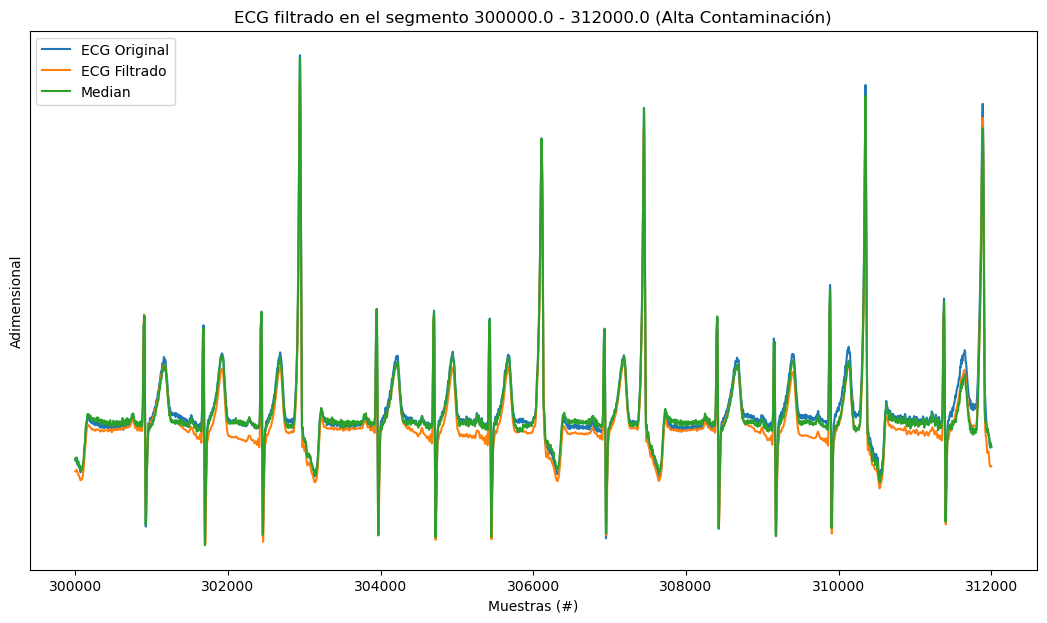

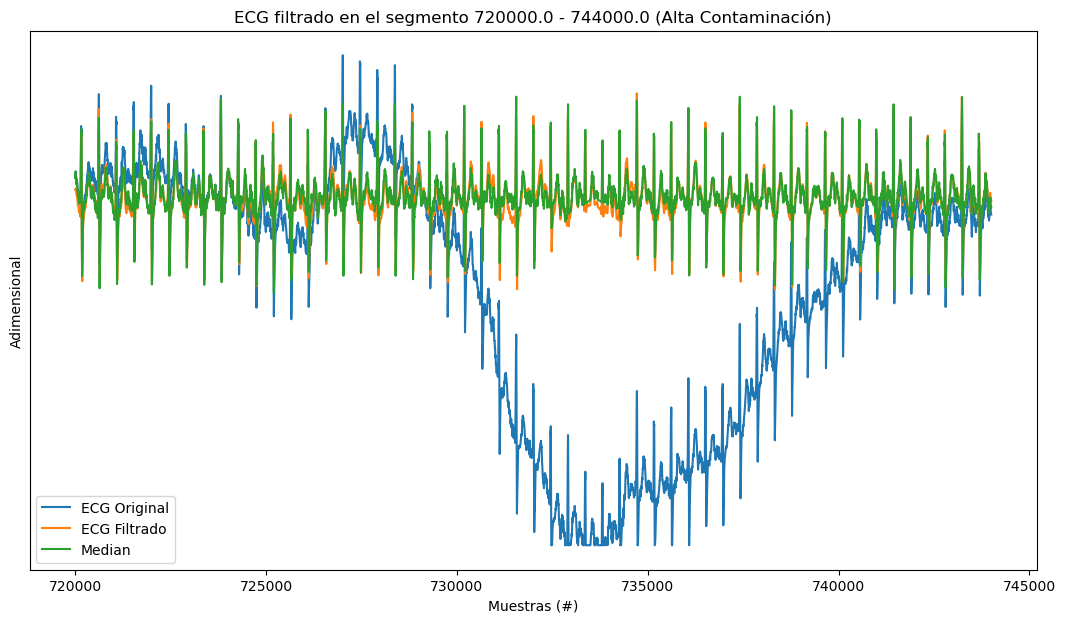

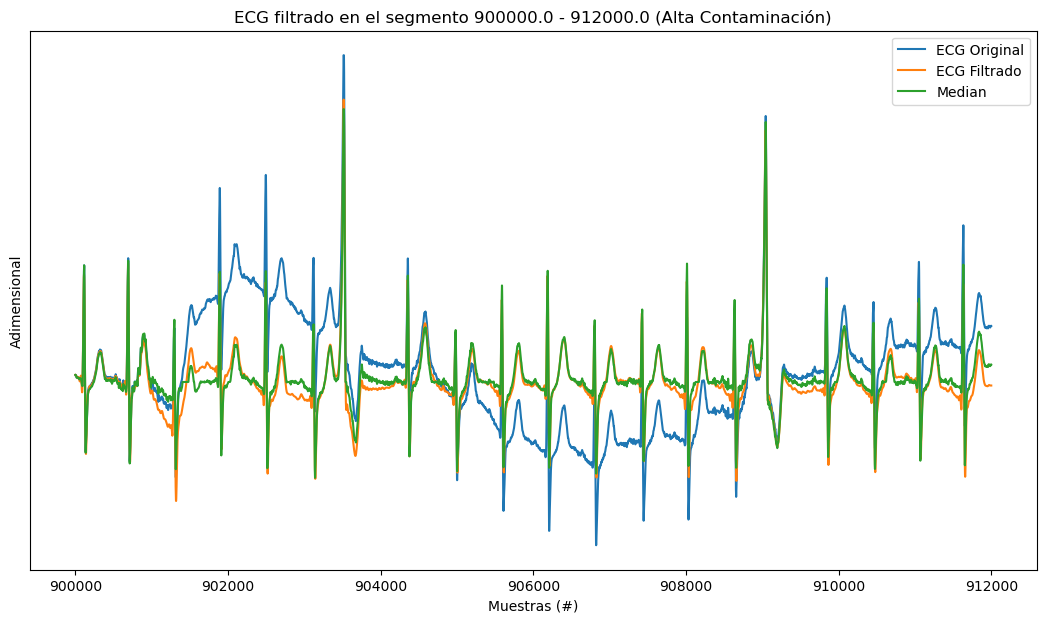

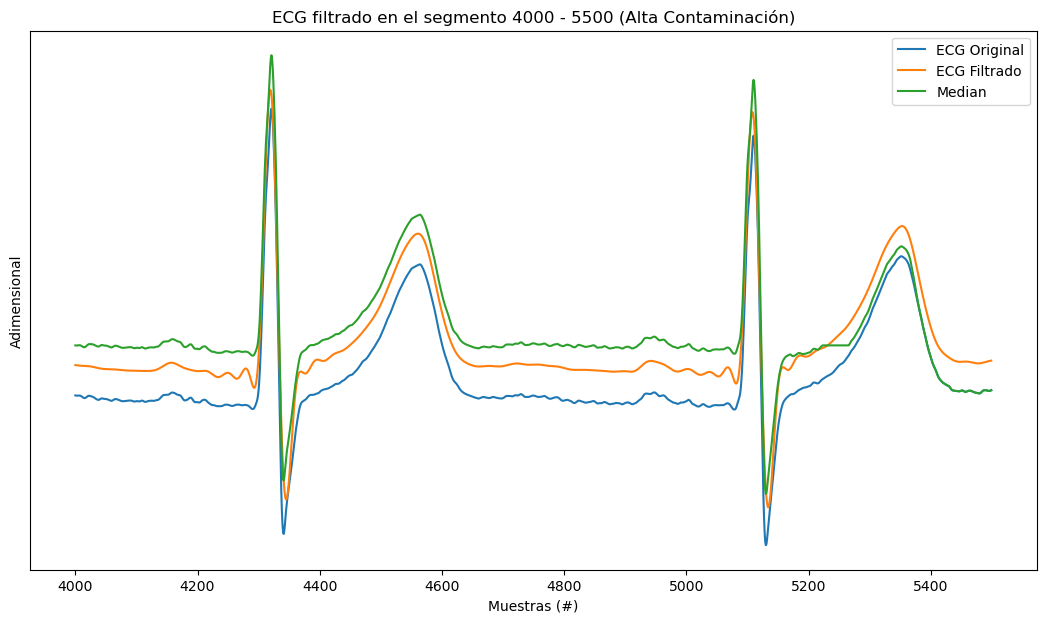

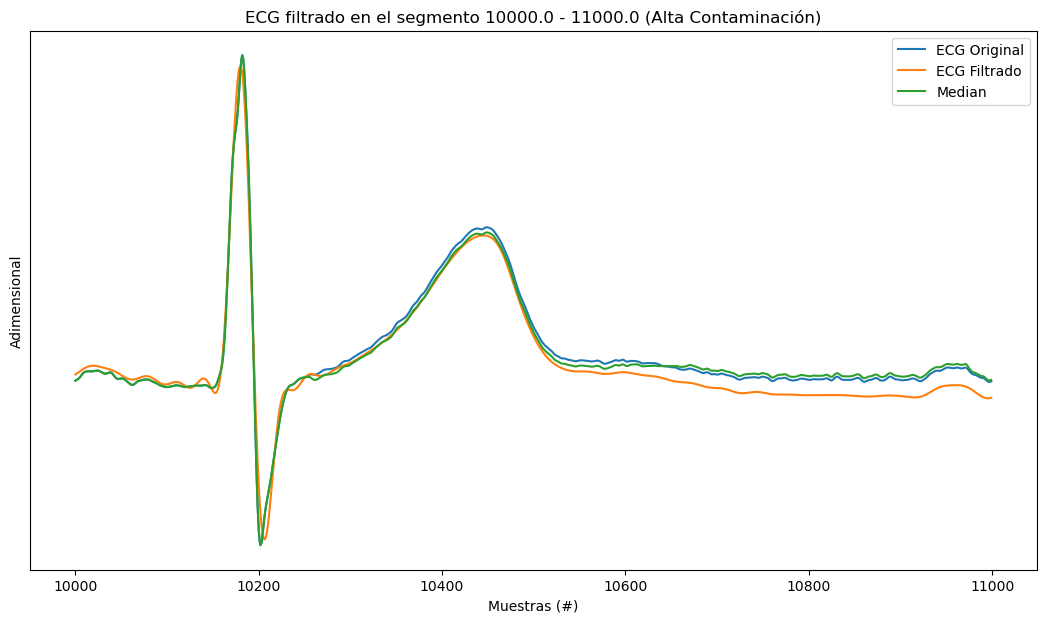

In [11]:
bp_sos_butter = sig.iirdesign([wp1, wp2], [ws1, ws2], ripple, atenuacion, ftype='butter', output='sos', fs=fs)
ECG_f_butt = sig.sosfiltfilt(bp_sos_butter, ecg_one_lead)
demora = 0 #Por el filtrado bidireccional

# Segmentos de interés
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    med_filt = sig.medfilt(sig.medfilt(ecg_one_lead[zoom_region], 201), 601)
    ecg_filt = ecg_one_lead[zoom_region] - med_filt
    
    plt.figure(facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG Original')
    plt.plot(zoom_region, ECG_f_butt[zoom_region + demora], label='ECG Filtrado')
    plt.plot(zoom_region, ecg_filt, label='Median')
    plt.title('ECG filtrado en el segmento ' + str(ii[0]) + ' - ' + str(ii[1]) + ' (Alta Contaminación)')
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())

#### Podemos observar que el filtro de mediana también elimina las contaminaciones de baja frecuencia pero además sigue de mejor manera a la señal que el filtro IIR, por ejemplo en los momentos previos a los latidos donde hay pequeñas variaciones de amplitud, por lo que es más fiel a la señal de origen. Algo negativo es que aparecen no linealidades, lo cual se esperaba ya que este es un proceso no lineal (ver cuarto gráfico luego de la muestra 5200).

### Estimación del espectro antes y después de los filtrados.

(0.0, 500.0)

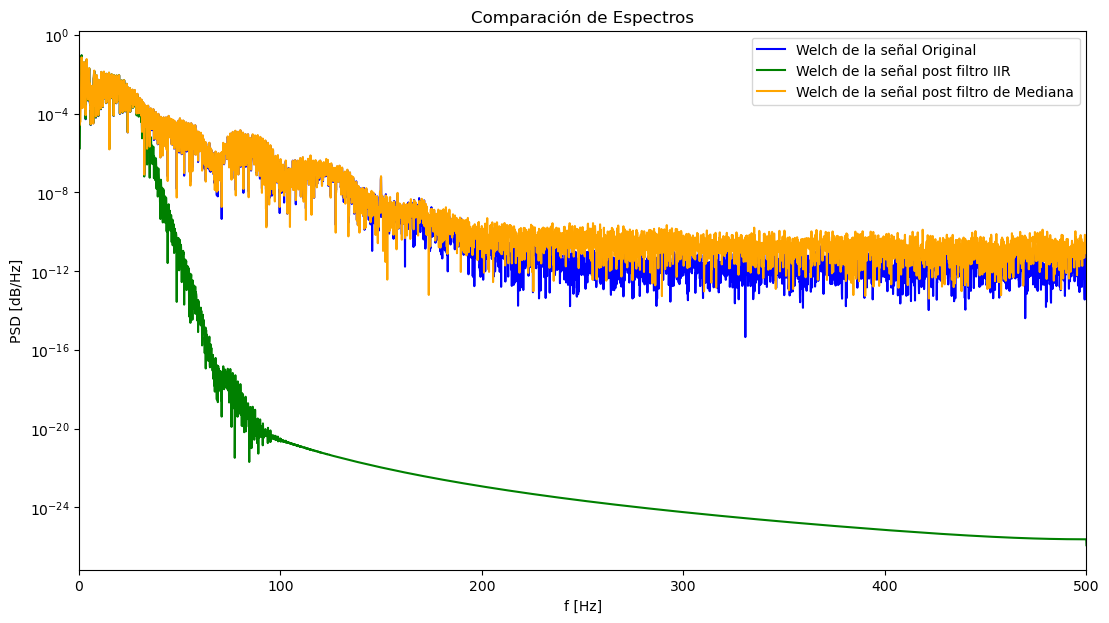

In [37]:
ecg_trim = ecg_one_lead[0:10000]                   #Primeros 10 segundos
N_trim = len(ecg_trim)

ecg_iir = sig.sosfiltfilt(bp_sos_butter, ecg_trim) #Aplico filtro IIR

med_filt = sig.medfilt(sig.medfilt(ecg_trim, 201), 601) #Aplico filtro de Mediana
ecg_median = ecg_trim - med_filt

freq_orig, welch_orig = sig.welch(ecg_trim, fs=fs, nperseg=N_trim, axis=0)
freq_iir, welch_iir = sig.welch(ecg_iir, fs=fs, nperseg=N_trim, axis=0)
freq_median, welch_median = sig.welch(ecg_median, fs=fs, nperseg=N_trim, axis=0)

welch_orig = welch_orig/np.sum(welch_orig)
welch_iir = welch_iir/np.sum(welch_iir)
welch_median = welch_median/np.sum(welch_median)

plt.figure();
plt.semilogy(freq_orig, welch_orig, color='blue', label='Welch de la señal Original')
plt.semilogy(freq_iir, welch_iir, color='green', label='Welch de la señal post filtro IIR')
plt.semilogy(freq_median, welch_median, color='orange', label='Welch de la señal post filtro de Mediana')
plt.title('Comparación de Espectros')
plt.xlabel('f [Hz]')
plt.ylabel('PSD [dB/Hz]')
plt.legend()
plt.xlim(0, 0)

#### Vemos que el filtro IIR pierde gran parte del contenido de alta frecuencia, lo cual se condice con lo mencionado anteriormente de que no sigue tan bien a las pequeñas variaciones de la señal original como el filtro de Mediana. 

(0.0, 5.0)

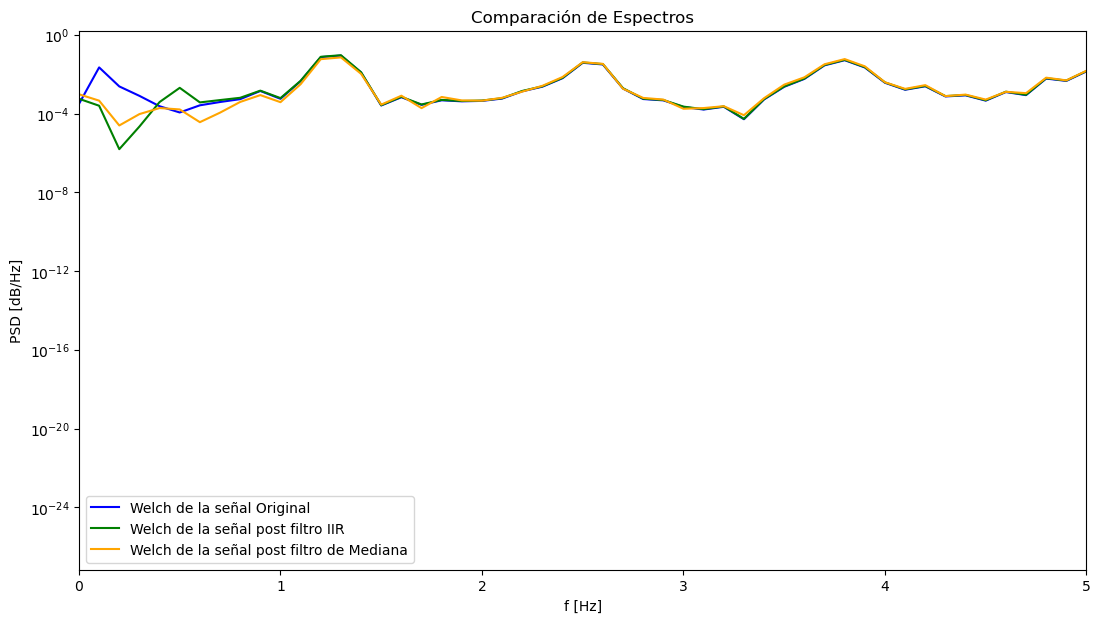

In [32]:
ecg_trim = ecg_one_lead[0:10000]                   #Primeros 10 segundos
N_trim = len(ecg_trim)

ecg_iir = sig.sosfiltfilt(bp_sos_butter, ecg_trim) #Aplico filtro IIR

med_filt = sig.medfilt(sig.medfilt(ecg_trim, 201), 601) #Aplico filtro de Mediana
ecg_median = ecg_trim - med_filt

freq_orig, welch_orig = sig.welch(ecg_trim, fs=fs, nperseg=N_trim, axis=0)
freq_iir, welch_iir = sig.welch(ecg_iir, fs=fs, nperseg=N_trim, axis=0)
freq_median, welch_median = sig.welch(ecg_median, fs=fs, nperseg=N_trim, axis=0)

welch_orig = welch_orig/np.sum(welch_orig)
welch_iir = welch_iir/np.sum(welch_iir)
welch_median = welch_median/np.sum(welch_median)

plt.figure();
plt.semilogy(freq_orig, welch_orig, color='blue', label='Welch de la señal Original')
plt.semilogy(freq_iir, welch_iir, color='green', label='Welch de la señal post filtro IIR')
plt.semilogy(freq_median, welch_median, color='orange', label='Welch de la señal post filtro de Mediana')
plt.title('Comparación de Espectros')
plt.xlabel('f [Hz]')
plt.ylabel('PSD [dB/Hz]')
plt.legend()
plt.xlim(0, 5)

#### Se aprecia que tanto el filtro IIR como el de Mediana atenúan las interferencias de muy baja frecuencia, por debajo de 1Hz.

### Estimación del movimiento de la línea de base a partir de la interpolación de los momentos isoeléctricos previos a cada latido.

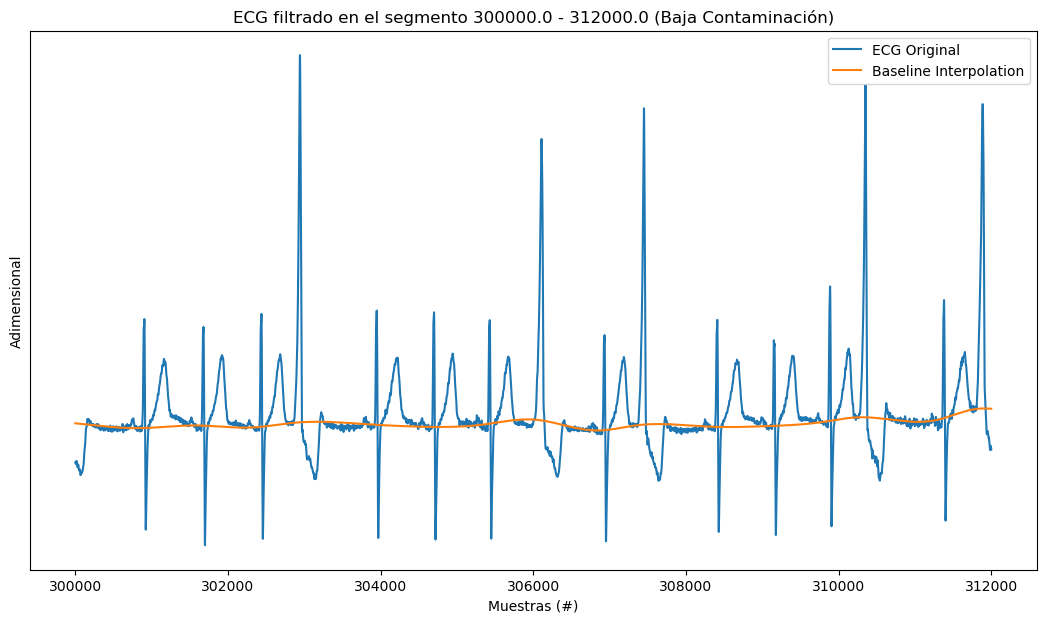

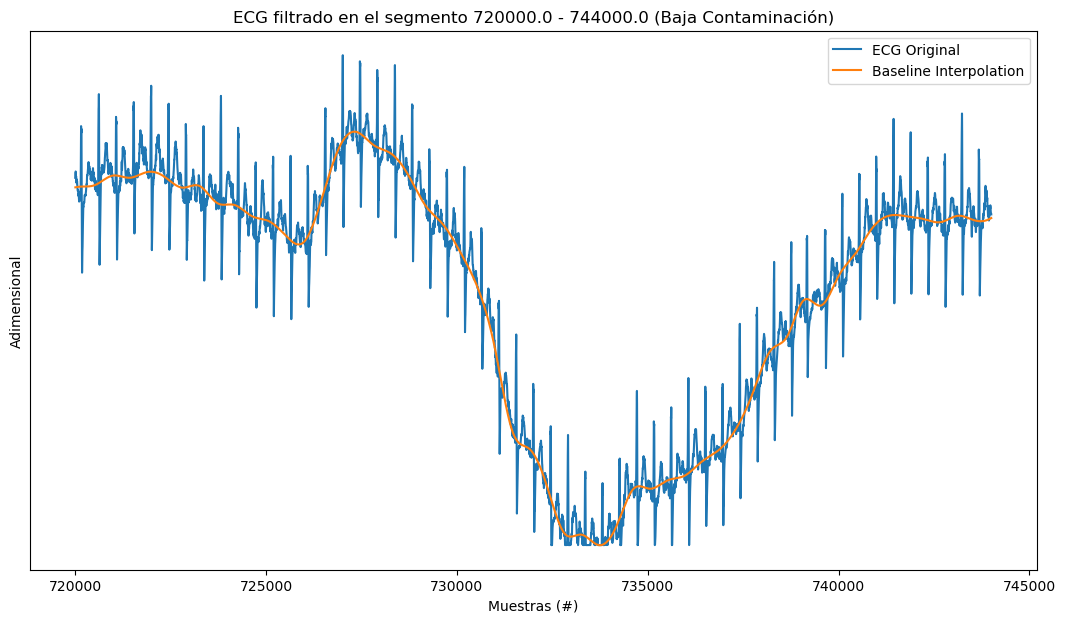

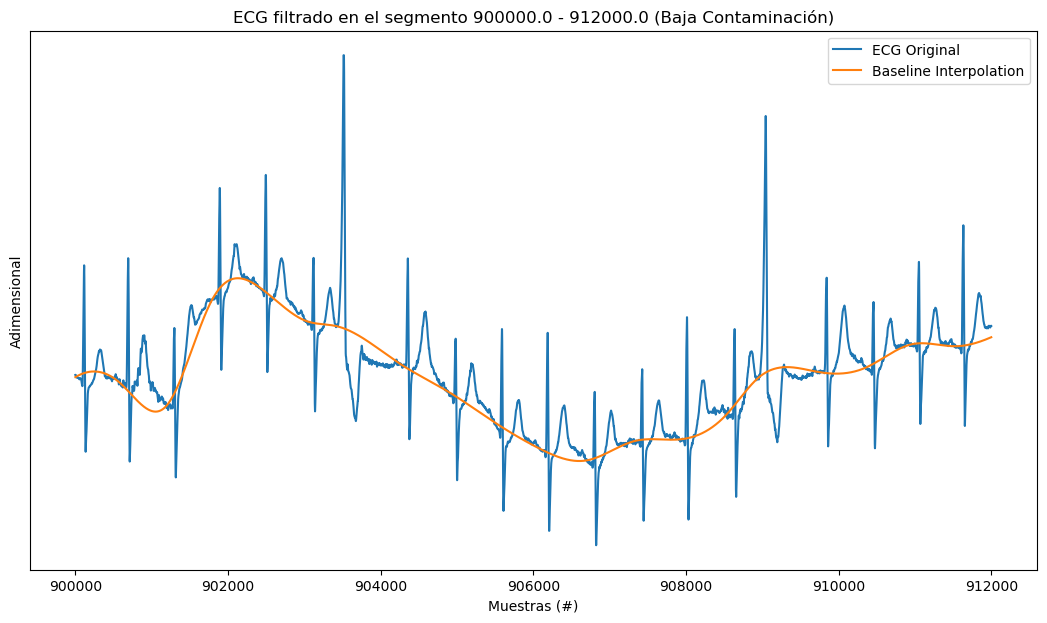

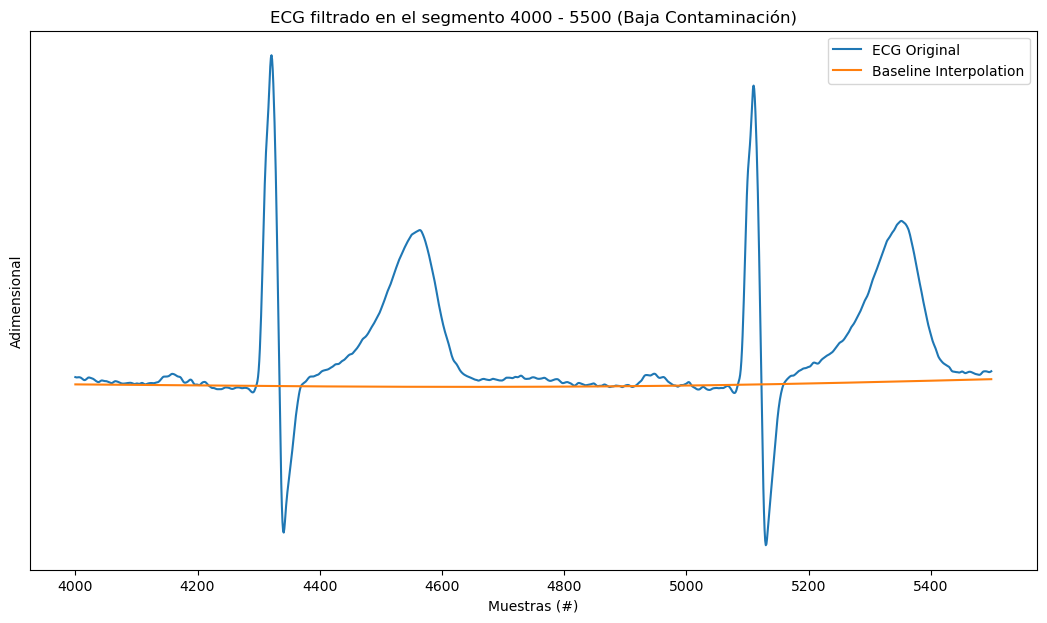

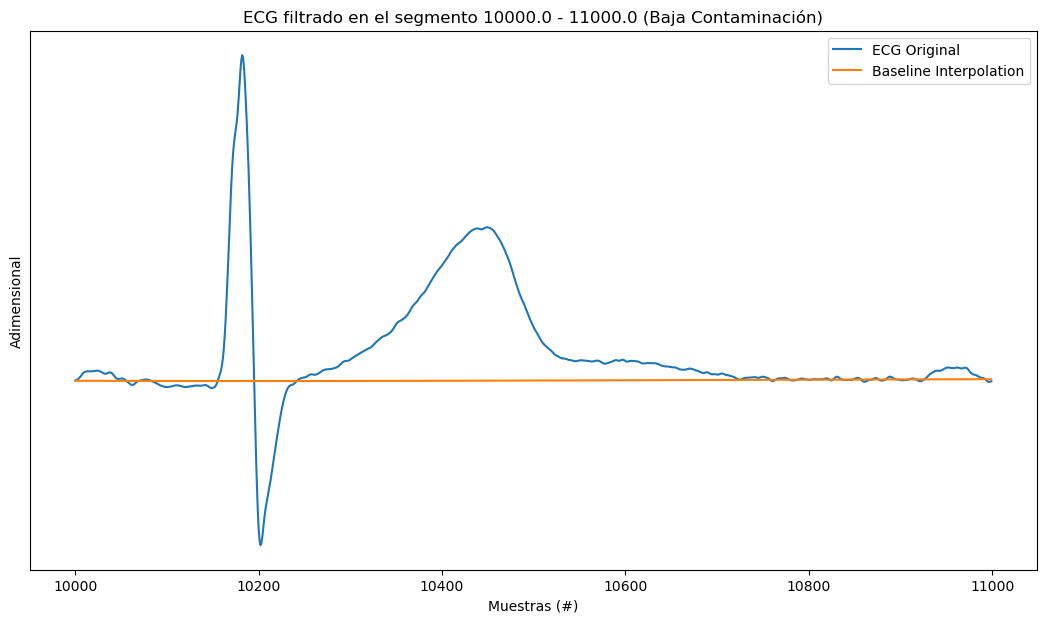

In [8]:
qrs_detections = mat_struct['qrs_detections'] #Deteción de latidos

k = np.zeros(len(qrs_detections))
v = np.zeros(len(qrs_detections))
for i in range(len(qrs_detections)):
    hb = int(qrs_detections[i])-100 #Momento previo al latido para evitar las ondas P y Q
    k[i] = hb
    v[i] = np.mean(ecg_one_lead[hb-10:hb+10]) #Promedio de 20 muestras alrededor del momento isoeléctrico para mitigar la interferencia de 50Hz

# Segmentos de interés
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')

    ecg_baseline = interpol.CubicSpline(k, v)
    x_interpol = np.linspace(zoom_region.min(), zoom_region.max(), 10*len(zoom_region))
    
    plt.figure(facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG Original')
    plt.plot(x_interpol, ecg_baseline(x_interpol), label="Baseline Interpolation")
    plt.title('ECG filtrado en el segmento ' + str(ii[0]) + ' - ' + str(ii[1]) + ' (Baja Contaminación)')
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())

#### Se observa que la interpolación funciona correctamente a la hora de estimar el nivel de base del ECG, pero necesita las detecciones de latidos para no utilizar puntos sobre la onda P o Q.